# Module

In [1]:
from glob import glob
import pandas as pd
import numpy as np
from tqdm import tqdm

# Data preprocessing

In [3]:
# train.csv path
df = pd.read_csv('/data/ephemeral/home/train/train.csv')
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [6]:
# Image path
data_path = '/data/ephemeral/home/train/images/'
data_list = sorted(glob(data_path + '*'))
data_list[:5]

['/data/ephemeral/home/train/images/000001_female_Asian_45',
 '/data/ephemeral/home/train/images/000002_female_Asian_52',
 '/data/ephemeral/home/train/images/000004_male_Asian_54',
 '/data/ephemeral/home/train/images/000005_female_Asian_58',
 '/data/ephemeral/home/train/images/000006_female_Asian_59']

In [7]:
new_data = []

for i in tqdm(range(len(data_list))):

  # 성별과 나이를 가져옵니다
  sex, age = data_list[i].split('/')[-1].split('_')[1],int(data_list[i].split('/')[-1].split('_')[-1])
  imgs_path = glob(data_list[i]+'/*')

  # 마스크 정보 받아오기
  labels = []

  for p in imgs_path:
    label = p.split('/')[-1][:-4]
    new_data.append([p, sex, age, label])


100%|██████████| 2700/2700 [00:00<00:00, 20655.68it/s]


In [8]:
# 정답 정보를 가진 새로운 dataframe 생성
new_df = pd.DataFrame(new_data, columns=['path', 'gender', 'age', 'mask'])
new_df.head()

,path,gender,age,mask
0,/data/ephemeral/home/train/images/000001_femal...,female,45,normal
1,/data/ephemeral/home/train/images/000001_femal...,female,45,mask1
2,/data/ephemeral/home/train/images/000001_femal...,female,45,mask3
3,/data/ephemeral/home/train/images/000001_femal...,female,45,mask2
4,/data/ephemeral/home/train/images/000001_femal...,female,45,mask4


In [9]:
# 나이 기준 정하기
def convert_age(age):

    if age < 30:
        return 0
    
    elif age < 60:
        return 1 
    else:
        return 2

In [10]:
# 나이 라벨로 변환
new_df['age'] = new_df.age.apply(convert_age)
new_df.tail()

,path,gender,age,mask
18895,/data/ephemeral/home/train/images/006959_male_...,male,0,mask3
18896,/data/ephemeral/home/train/images/006959_male_...,male,0,mask2
18897,/data/ephemeral/home/train/images/006959_male_...,male,0,mask4
18898,/data/ephemeral/home/train/images/006959_male_...,male,0,incorrect_mask
18899,/data/ephemeral/home/train/images/006959_male_...,male,0,mask5


# Holdout

In [11]:
from sklearn.model_selection import train_test_split
from PIL import Image

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df['path'].values, new_df['age'].values, test_size=0.3, random_state=42)
print('Shape of X train : ',X_train.shape)
print('Shape of y train : ',y_train.shape)
print('Shape of X valid : ',X_valid.shape)
print('Shape of y valid : ',y_valid.shape)

Shape of X train :  (13230,)
Shape of y train :  (13230,)
Shape of X valid :  (5670,)
Shape of y valid :  (5670,)


# Dataset

In [13]:
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

In [14]:
def get_transforms(need=('train', 'val'), img_size=(224, 224), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):

    transformations = {}
    if 'train' in need:
        transformations['train'] = A.Compose([
            A.ColorJitter(),
            ToTensorV2(),
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = A.Compose([
             ToTensorV2(),
        ], p=1.0)
    return transformations

In [15]:
class MaskDataset(Dataset):
    def __init__(self, path,y,transform,train):
        self.path = path
        self.y = y
        self.transforms = transform
        self.train = train

    def __len__(self):
        return len(self.path)

    def __getitem__(self,idx):
        img_path = self.path[idx]
        img = Image.open(img_path).convert(mode='RGB')
        label = torch.tensor(self.y[idx]).long()
        if self.transforms:
            if self.train:
              img = self.transforms['train'](image=np.array(img))['image']
            else:
              img = self.transforms['val'](image=np.array(img))['image']
        img = (img / 255).float()

        if self.train:
            return img, label
        else:
            return img_path, img, label

In [16]:
train_transform = get_transforms(need=('train'))
val_transform = get_transforms(need=('val'))

trainset = MaskDataset(X_train,y_train,train_transform,True)
validset = MaskDataset(X_valid, y_valid, val_transform, False)

In [17]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validloader = DataLoader(validset, batch_size=16, shuffle=False)

# Model

In [18]:
from torchvision.models import resnet50
from torch import nn
import torch

In [19]:
# 모형 생성
resnet = resnet50(weights='IMAGENET1K_V1')
resnet.fc = nn.Linear(2048,3)

In [31]:
# 장치 설정
device = torch.device('cuda')
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
# 손실 함수 및 optimizer 정의
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(),lr=1e-3)
scaler = torch.cuda.amp.GradScaler()

# 학습

In [36]:
# Training
def train(epoch, model, dataloader, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()*inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = train_loss/total
    epoch_acc = correct/total*100
    print("Train | Loss:%.4f Acc: %.2f%% (%s/%s)"
        % (epoch_loss, epoch_acc, correct, total))
    return epoch_loss, epoch_acc

In [37]:
# 추론
def test(epoch, model, dataloader,criterion, optimizer):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (_,inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()*inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = test_loss/total
        epoch_acc = correct/total*100
        print("Test | Loss:%.4f Acc: %.2f%% (%s/%s)"
            % (epoch_loss, epoch_acc, correct, total))
    return epoch_loss, epoch_acc

In [41]:
import time
import copy

start_time = time.time()
best_loss = 9999999
best_model_wts = copy.deepcopy(resnet.state_dict())
epoch_length = 100
patience = 3
i = 0
save_loss = {"train":[],
             "val":[]}
save_acc = {"train":[],
             "val":[]}
for epoch in range(epoch_length):
    print("Epoch %s" % epoch)
    train_loss, train_acc = train(epoch, resnet,trainloader, loss_fn, optimizer)
    save_loss['train'].append(train_loss)
    save_acc['train'].append(train_acc)

    val_loss, val_acc = test(epoch, resnet,validloader,loss_fn, optimizer)
    save_loss['val'].append(val_loss)
    save_acc['val'].append(val_acc)

    # Save model
    if val_loss <= best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(resnet.state_dict())
        i = 0
    else:
        i += 1
        if i >= patience:
            print('Early Stopping')
            break

learning_time = time.time() - start_time
print(f'**Learning time: {learning_time // 60:.0f}m {learning_time % 60:.0f}s')

Epoch 0
Train | Loss:1.1006 Acc: 70.66% (9348/13230)
Test | Loss:0.6730 Acc: 75.54% (4283/5670)
Epoch 1
Train | Loss:0.4275 Acc: 83.91% (11101/13230)
Test | Loss:0.3828 Acc: 86.38% (4898/5670)
Epoch 2
Train | Loss:0.3062 Acc: 88.41% (11697/13230)
Test | Loss:0.2677 Acc: 89.14% (5054/5670)
Epoch 3
Train | Loss:0.2538 Acc: 89.99% (11906/13230)
Test | Loss:0.2638 Acc: 89.77% (5090/5670)
Epoch 4
Train | Loss:0.2012 Acc: 92.07% (12181/13230)
Test | Loss:0.2299 Acc: 90.79% (5148/5670)
Epoch 5
Train | Loss:0.1687 Acc: 93.20% (12330/13230)
Test | Loss:0.2135 Acc: 91.69% (5199/5670)
Epoch 6
Train | Loss:0.1433 Acc: 94.16% (12458/13230)
Test | Loss:0.2659 Acc: 91.01% (5160/5670)
Epoch 7
Train | Loss:0.1192 Acc: 95.31% (12610/13230)
Test | Loss:0.2486 Acc: 90.58% (5136/5670)
Epoch 8
Train | Loss:0.0974 Acc: 96.35% (12747/13230)
Test | Loss:0.1464 Acc: 94.27% (5345/5670)
Epoch 9
Train | Loss:0.0808 Acc: 96.98% (12830/13230)
Test | Loss:0.1595 Acc: 93.95% (5327/5670)
Epoch 10
Train | Loss:0.0622 Ac

In [42]:
torch.save(best_model_wts,'ResNet50_Age.pth')

In [44]:
# 학습한 가중치 불러오기
resnet.load_state_dict(torch.load('ResNet50_Age.pth',map_location='cpu'))

<All keys matched successfully>

In [45]:
# Evaluation mode
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# GradCAM

In [46]:
# 최적화 알고리즘
from torch.optim import optimizer
from torch.autograd import Variable
import skimage

import random
import copy

In [47]:
# 장치 설정
device = torch.device('cpu')

In [48]:
# Get validation img path
paths, img,_ = next(iter(validloader))
paths[:5]

('/data/ephemeral/home/train/images/006384_male_Asian_19/mask5.jpg',
 '/data/ephemeral/home/train/images/003044_female_Asian_20/mask2.jpg',
 '/data/ephemeral/home/train/images/005119_male_Asian_19/mask5.jpg',
 '/data/ephemeral/home/train/images/003046_female_Asian_20/normal.jpg',
 '/data/ephemeral/home/train/images/003847_male_Asian_58/incorrect_mask.jpg')

In [49]:
class RESNET_gradcam(nn.Module):
    def __init__(self):
        super().__init__()
        # 기존 모델 호출
        self.model = copy.deepcopy(resnet) # resnet 호출

        # gradient 추출을 위해 마지막 convolution layer 추출
        self.conv = nn.Sequential(self.model.conv1, self.model.bn1, self.model.relu, self.model.maxpool,
                     self.model.layer1, self.model.layer2, self.model.layer3, self.model.layer4)

        # convolution 이후 수행되던 avgpool 다시 삽입
        self.avgpool = self.model.avgpool 

        # 기존 모델에서 사용되던 classifier(fc) 삽입
        self.classifier = self.model.fc

        # 낚아챈 gradient 를 저장하기 위해 변수 선언
        # 최초에는 None, forward 과정에서 hooking 됨
        self.gradient = None

    # activation map의 gradient를 hooking
    def  activations_hook(self, grad):
        self.gradient = grad
        
    def forward(self,x):
        x = self.conv(x)
        self.conv_result = x

        # gradient 저장
        h = x.register_hook(self.activations_hook)

        # max pool 적용
    
        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        
        x = self.classifier(x)

        self.prediction = x.argmax()
        self.logits = x
        return x


In [51]:
mean=(0.548, 0.504, 0.479)
std=(0.237, 0.247, 0.246)

In [52]:
img = plt.imread(imgs_path[0])
# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.548, 0.504, 0.479),std=(0.237, 0.247, 0.246))
])
img = transform(img)

In [53]:
def show_grad_cam(path):
    img_0 = plt.imread(path)
    img = transform(img_0)

    model = RESNET_gradcam()
    model.to(device)
    
    model.eval()

    pred = model(img.unsqueeze(0))
    pred[:][0][pred.argmax()].backward()

    pooled_gradient = torch.mean(model.gradient, dim=[0, 2, 3])

    # feature map 획득
    feature_map =  model.conv(img.unsqueeze(0))

    # pooled_gradient * feature map
    for i in range(len(pooled_gradient)):
        feature_map[:,i,:,:] *= pooled_gradient[i]

    # 전체 차원 평균 해주기
    mean_feature_map = torch.mean(feature_map, dim=1)

    # relu를 적용하여 heatmap 획득
    heatmap = np.maximum(mean_feature_map.detach().cpu(), 0) # shape : (1, 16, 12)
    heatmap /= torch.max(heatmap) # 최대값으로 나누어 정규화
    heatmap = heatmap.squeeze() # 차원 줄이기, shape (16, 12)
  
    mask = skimage.transform.resize(heatmap.detach().numpy(), (512,384))
    image = skimage.transform.resize(img_0, (512,384))


    plt.figure(figsize=(15,5))

    # 원본 이미지 출력
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original')

    # heatmap 출력
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.axis('off')
    plt.title('heatmap')


    plt.subplot(1,3,3)
    # CAM 결과와 함께 출력
    plt.imshow(mask, cmap='jet')
    plt.imshow(image, alpha=0.4)
    plt.axis('off')
    plt.title('Grad-CAM')
    plt.show()
    

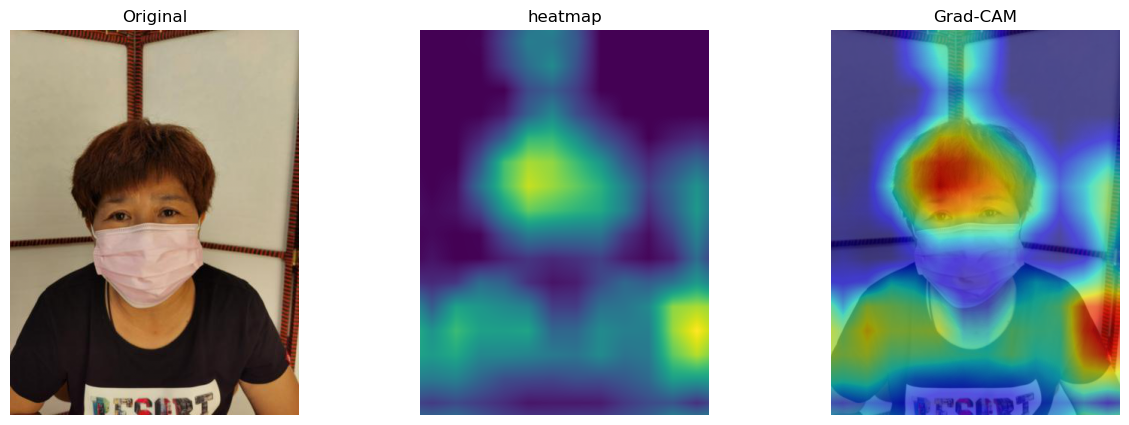

In [55]:
show_grad_cam(new_df.path[11])

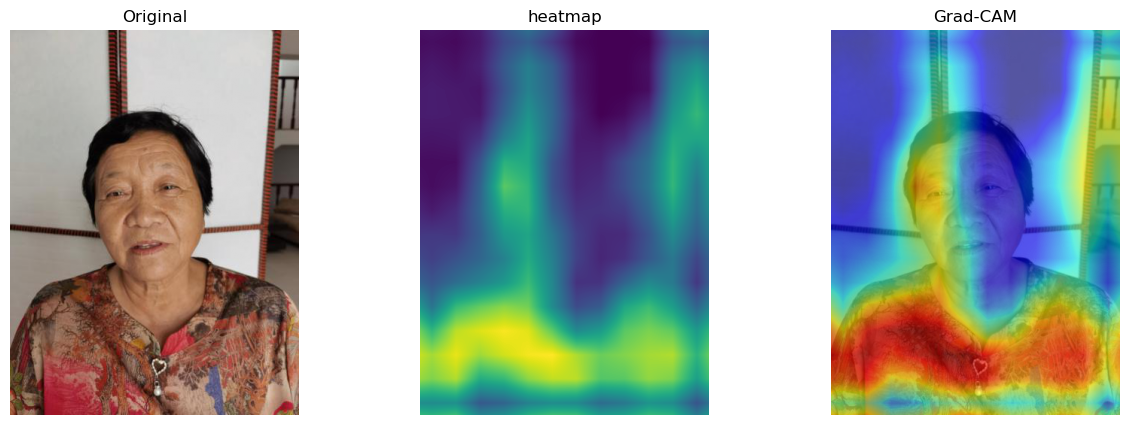

In [57]:
show_grad_cam(new_df.path[21])

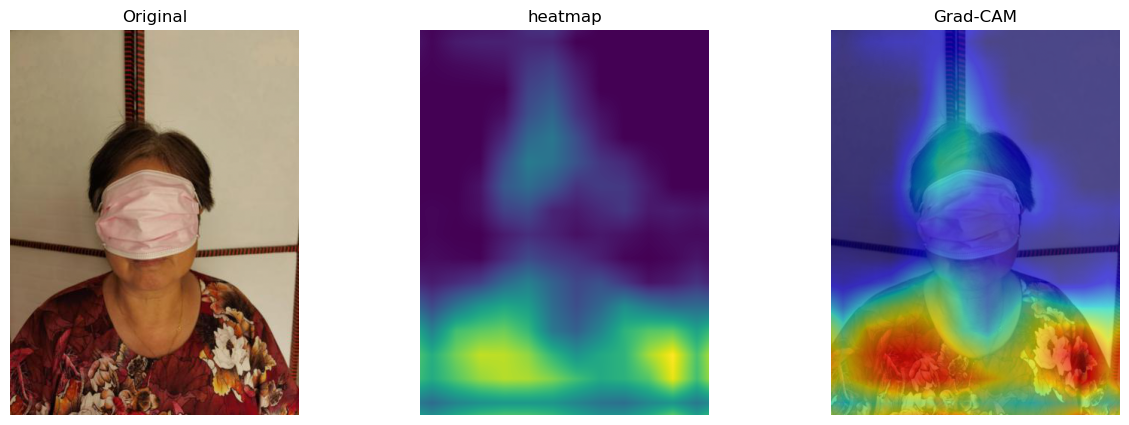

In [58]:
show_grad_cam(new_df.path[33])

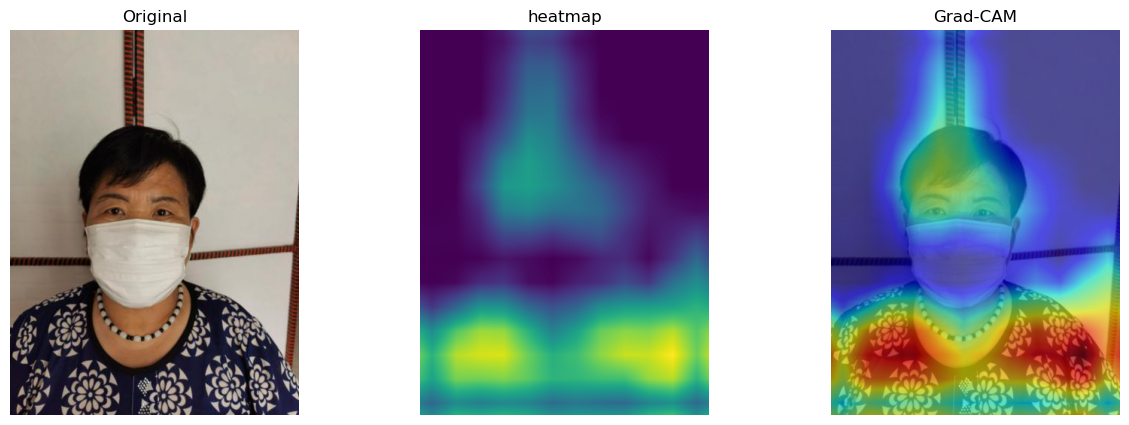

In [59]:
show_grad_cam(new_df.path[37])

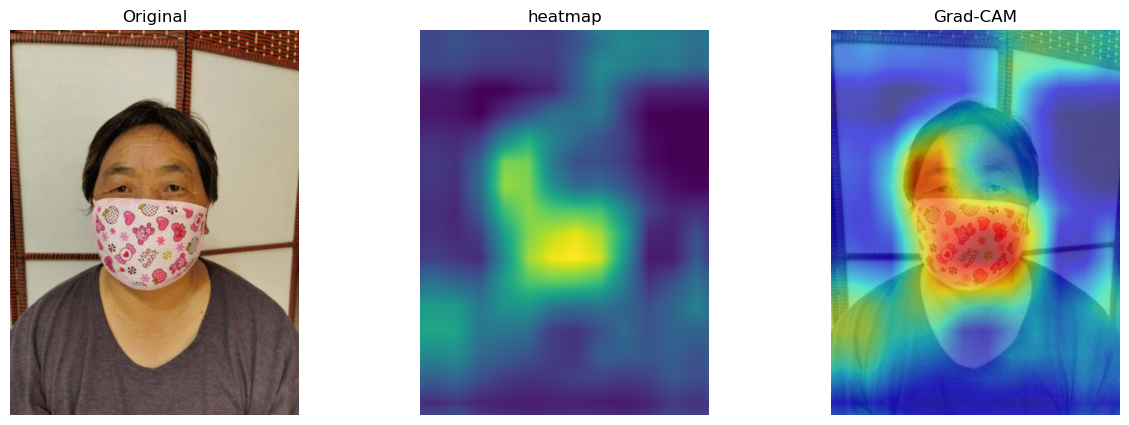

In [62]:
show_grad_cam(new_df.path[62])

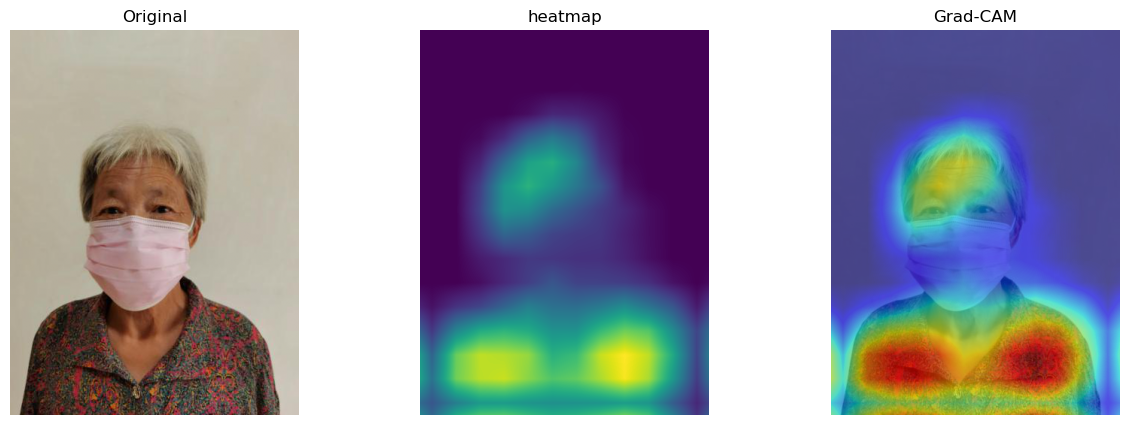

In [66]:
show_grad_cam(new_df.path[221])

배경보다는 마스크 윗쪽 또는 입은 옷을 기준으로 나이를 판별하는 것을 알 수 있음